In [1]:
using Revise
using TaD
using DifferentialEquations, Flux, DiffEqFlux
using Plots
import IJulia

# BSpline trajectory

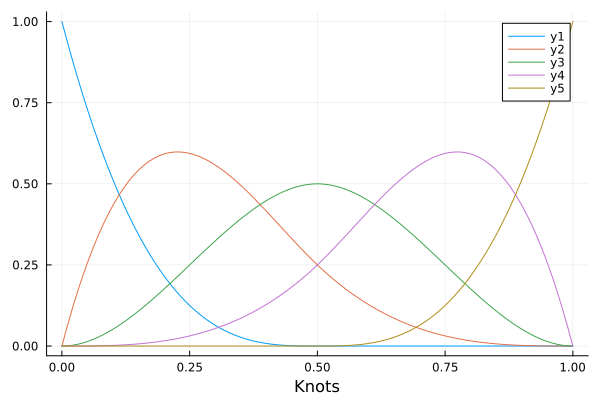

In [2]:
kv = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
basis = BSplineBasis(kv, 3, k=3)
plot(basis, k=0)

In [3]:
control_points = [0.0 0.0 0.0; 0.1 0.1 0.75; 0.0 0.0 1.0; 0.25 0.25 0.9; 1.0 1.0 1.0]
c = BSplineCurve(basis, control_points)
c(1.0)

4×3 Matrix{Float64}:
  1.0   1.0   1.0
  4.5   4.5   0.6
 15.0  15.0   3.6
 25.8  25.8  11.4

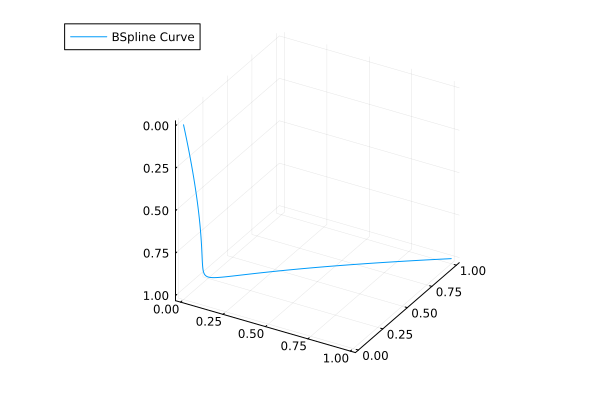

In [4]:
plot(c, zflip=true)

# Forward solution

For demonstration purposes, we'll be solving the soft string equation:

$$\frac{dF_t}{ds} = -w_{bp} \hat{t}_3 + \mu w_c,$$

where

$$w_{bp} = A g (\rho_p - \rho_m),$$

and

$$w_c = \sqrt{\left(F_t \kappa + w_{bp} \hat{n}_3\right)^2 + \left(w_{bp} \hat{b}_3 \right)^2}.$$

$\hat{t}, \hat{n}, \hat{b}$ are the tangential, normal, and bi-normal vectors in the Frenet frame that follows the drillstring trajectory.  From the position vector along trajectory curve defined by the B-Splines $\vec{r} = \vec{r}(s)$ these are defined as

$$\hat{t} = \frac{\vec{r}^\prime}{\left\Vert \vec{r}^\prime \right\Vert},$$

$$\hat{b} = \frac{\vec{r}^{\prime\prime}}{\left\Vert \vec{r}^{\prime\prime} \right\Vert},$$

$$\hat{n} = \hat{t} \times \hat{b},$$

and finally, $\kappa$ is the curvature defined by

$$\kappa = \frac{\left\Vert \vec{r}^{\prime} \times \vec{r}^{\prime\prime} \right\Vert}{\left\Vert \vec{r}^\prime \right\Vert^3}$$.

$\mu$ is the friction factor, $\rho_p$ and $\rho_m$ are the densities of the drill pipe and drilling mud respectively, $A$ is the cross-sectional area of the pipe, and $g$ is acceration due to gravity.

In [5]:
function parameterized_soft_string_drag1!(dF,F,p,s)
    kv = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
    basis = BSplineBasis(kv, 3, k=3)
    control_points = [0.0 0.0 0.0; 0.1 0.1 0.75; 0.0 0.0 1.0; 0.25 0.25 0.9; 1.0 1.0 1.0]
    c = BSplineCurve(basis, control_points)
    
    p_ = [p[1], 0.1683, 0.09525, 9.81, 7800, 1298, c]
    soft_string_drag!(dF, F, p_, s)
end

parameterized_soft_string_drag1! (generic function with 1 method)

In [6]:
u0 = [0.0]
tspan = (1.0,0.0)
prob1 = ODEProblem(parameterized_soft_string_drag1!, u0, tspan, 0.2, saveat=0.05)
sol1 = solve(prob1)
scatter(sol1, xlabel="s", ylabel="Axial Force (N)", legend=false)


μ = [0.0]
params = Flux.params(μ)

function predict_tad1() # Our 1-layer "neural network"
  solve(prob1,p=μ,saveat=0.05)[1,:] # override with new parameters
end


loss1() = sum(abs2,x-sol1[1,i] for (i,x) in enumerate(predict_tad1())) # loss function




loss1 (generic function with 1 method)

# Parameter estimation

The goal here is to solve the following minimization problem

$$\frac{\partial}{\partial \mu}\left(y_{data} - \int_{s_b}^0 \frac{dF_t(\mu, s)}{ds} ds\right)^2 = 0$$

"Loss: 24.989502712390333"

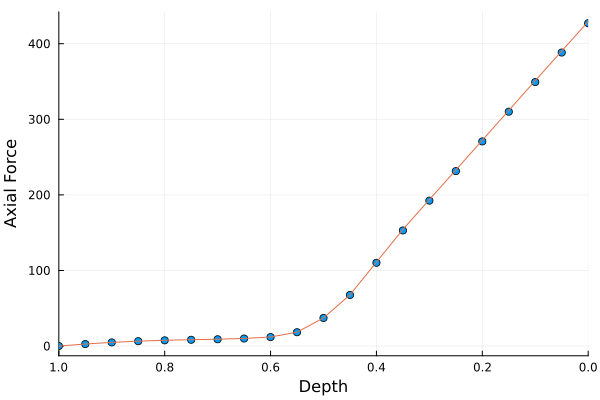

LoadError: Stopping training!

In [7]:
dat = Iterators.repeated((), 100)

cb = function () #callback function to observe training
  sleep(0.1)
  IJulia.clear_output(true)
  IJulia.display("Loss: $(loss1())")
  # using `remake` to re-create our `prob` with current parameters `p`
  scatter(sol1, xlabel = "Depth", ylabel = "Axial Force", legend=false)
  IJulia.display(plot!(solve(remake(prob1,p=μ),saveat=0.05), xlabel="Depth", legend=false))
  if loss1() < 40.0
    throw(ErrorException("Stopping training!"))
    #flux.stop() is deprecated i think
  end
end

# Display the ODE with the initial parameter values.
cb()

for i in 1:6
    @info "Epoch $i"
    Flux.train!(loss1, params, dat, ADAM(), cb = cb)
end

# SciML

First let's consider a spatially varying friction factor of the form

$$\mu(s) = 0.9 s^3 + 0.001$$

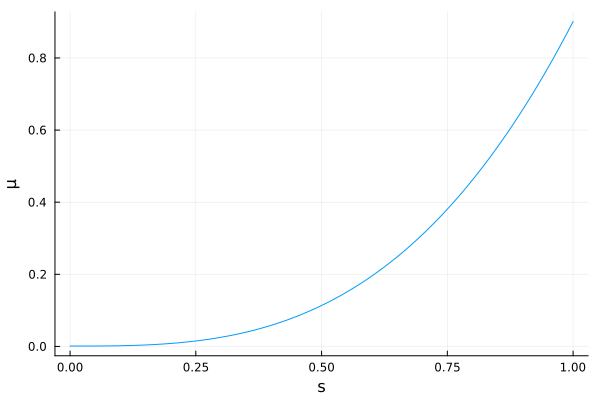

In [104]:
μf(x) = 0.9 * x ^ 3 + 0.001
plot(0:0.01:1, μf, xlabel="s", ylabel="μ",legend=false)

In [105]:
function parameterized_soft_string_drag2!(dF,F,p,s)
    kv = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
    basis = BSplineBasis(kv, 3, k=3)
    control_points = [0.0 0.0 0.0; 0.1 0.1 0.75; 0.0 0.0 1.0; 0.25 0.25 0.9; 1.0 1.0 1.0]
    c = BSplineCurve(basis, control_points)
    p_ = [μf(s), 0.1683, 0.09525, 9.81, 7800, 1298, c]
    soft_string_drag!(dF, F, p_, s)
end

parameterized_soft_string_drag2! (generic function with 1 method)

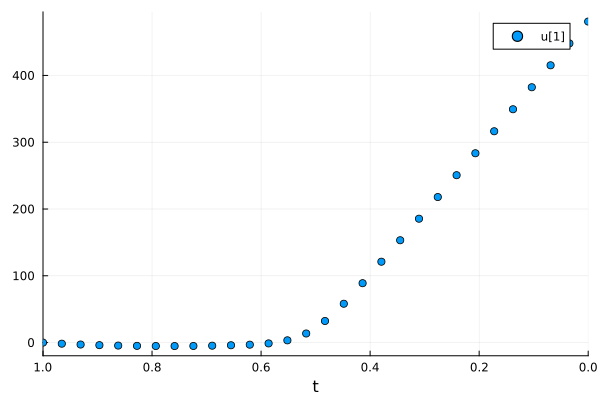

In [112]:
μ0 = [0.0]
datasize = 30
tspan = (1.0, 0.0)
tsteps = range(tspan[1], tspan[2]; length = datasize)
prob2 = ODEProblem(parameterized_soft_string_drag2!, u0, tspan, saveat=tsteps)
sol2 = solve(prob2)
ode_data = Array(sol2)
scatter(sol2)

The goal now is to solve the following minimization problem

$$\frac{\partial}{\partial \theta}\left(y_{data} - \int_{s_b}^0 \frac{dF_t\left(\mathcal{NN}_{\theta}(s)\right)}{ds} ds\right)^2 = 0$$

where $F_t$ is

$$\frac{dF_t}{ds} = -w_{bp} \hat{t}_3 + \mathcal{NN}_{\theta}(s) w_c,$$

In [113]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL, OptimizationOptimisers, Random, Plots, TaD

rng = Random.default_rng()
dudt2 = Lux.Chain(Lux.Dense(1, 50, tanh), Lux.Dense(50, 1)) #The second dimension must be equal to length μ0. First is bc odedata has length 50

p, st = Lux.setup(rng, dudt2)
tad_3 = NeuralODE(dudt2, tspan, Tsit5(); saveat = tsteps);

In [114]:
function predict_tad3(p)
    #Array(prob_neuralode(u0, p, st)[1])
    Array(tad_3(μ0, p, st)[1])
end

function loss3(p)
    pred = predict_tad3(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

loss3 (generic function with 1 method)

Iteration 1 has loss 1.2483127334149755e6


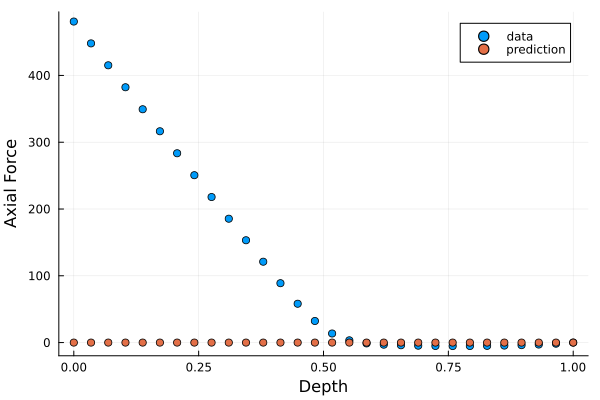

Iteration 5 has loss 251731.3914858797
Iteration 10 has loss 123610.02509713448
Iteration 15 has loss 636.577361228524
Iteration 16 has loss 473.908661505637


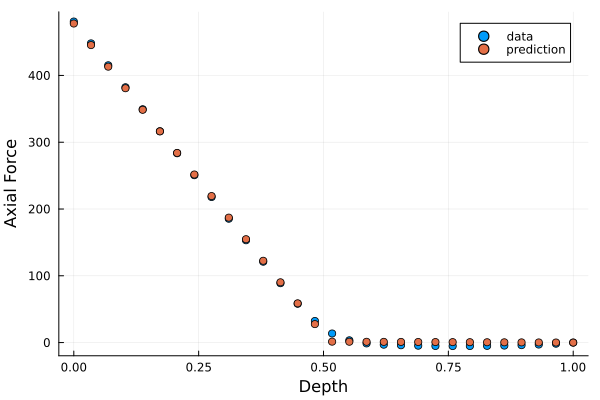

LoadError: Stopping training!

In [115]:
#This will work most times but BFGS is unstable for some reason and will occasionally throw an
# error while calling internal function "reset_search_direction"
#Most of the time for me it gets to error of abt ~500
cnt = [0]
callback = function (p, l, pred; doplot = false)
    cnt[1] = cnt[1]+1
    if cnt[1] % 5 == 0 || doplot
        println("Iteration $(cnt[1]) has loss $(l)")
    end
    if doplot
        plt = scatter(tsteps, ode_data[1, :]; label = "data", xlabel="Depth", ylabel="Axial Force")
        scatter!(plt, tsteps, pred[1, :]; label = "prediction", xlabel="Depth", ylabel="Axial Force")
        IJulia.display(plot(plt))
    end
    if l < 500.0
        println("Iteration $(cnt[1]) has loss $(l)")
        plt = scatter(tsteps, ode_data[1, :]; label = "data", xlabel="Depth", ylabel="Axial Force")
        scatter!(plt, tsteps, pred[1, :]; label = "prediction", xlabel="Depth", ylabel="Axial Force")
        IJulia.display(plot(plt))
        throw(ErrorException("Stopping training!"))
        #flux.stop() is deprecated i think
    end
    return false
end

pinit = ComponentArray(p)
callback(pinit, loss3(pinit)...; doplot = true)

# use Optimization.jl to solve the problem
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> loss3(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

#result_neuralode = Optimization.solve(optprob, OptimizationOptimJL.BFGS(; initial_stepnorm = .001); callback = callback, maxiters=10000)
#result_neuralode = Optimization.solve(optprob, Optim.ConjugateGradient(); callback = callback, maxiters=10000)
#result_neuralode = Optimization.solve(optprob, Optim.NelderMead(); callback = callback)
result_neuralode = Optimization.solve(optprob, Optim.BFGS(; initial_stepnorm = .01); callback = callback, maxiters=1000)

#callback(result_neuralode.u, loss3(result_neuralode.u)...; doplot = true)

# Things to do

 * Trajectory reconstruction from survey data
 * Validate models
 * Train SciML models w/ real data